In [1]:
import sys
parentdir = ".."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 100.0.4896
[WDM] - Get LATEST driver version for 100.0.4896
[WDM] - Driver [/Users/gaignard-a/.wdm/drivers/chromedriver/mac64/100.0.4896.60/chromedriver] found in cache


# Retrieve a Bioschemas RDF dump

In [2]:
dump = "bioschemas-dump.ttl"
if not path.isfile(dump):
    r = requests.get("https://github.com/bio-tools/content/raw/master/datasets/bioschemas-dump.ttl")
    assert r.status_code == 200
    with open(dump, "wb") as f:
        f.write(r.content)

assert path.isfile(dump)

# Load the RDF dump

In [3]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

In [4]:
KG = ConjunctiveGraph()
KG.parse(dump, format="turtle")
print(f"{len(KG)} loaded triples")

483678 loaded triples


In [5]:
index = {}
for s, p, o in KG.triples((None, RDF.type, schema.SoftwareApplication)):
    index[str(s)] = None    
print(print(f"{len(index)} software applications"))

25048 software applications
None


In [6]:
def index_dump():
    for i in tqdm(index.keys()):
        sub_graph = ConjunctiveGraph()
        for s, p, o in KG.triples((URIRef(i), None, None)):
            sub_graph.add((s, p, o))
        index[i]=sub_graph


def get_RDF_sparql(bio_tools_Id):
    q = f"CONSTRUCT {{<{bio_tools_Id}> ?p ?o}} WHERE {{<{bio_tools_Id}> rdf:type schema:SoftwareApplication . <{bio_tools_Id}> ?p ?o .}}"
    res = KG.query(q)
    print(res.serialize(format="turtle"))

def get_RDF(bio_tools_Id):
    sub_graph = ConjunctiveGraph()
    for s, p, o in KG.triples((URIRef(bio_tools_Id), None, None)):
        sub_graph.add((s, p, o))
    print(sub_graph.serialize(format="turtle"))    
    
#get_RDF_sparql("https://bio.tools/bwa")
#get_RDF("https://bio.tools/bwa")

In [7]:
index_dump()

  0%|          | 0/25048 [00:00<?, ?it/s]

In [8]:
import random
#sample_tool = random.choice(index.keys())

random.seed(10)

#samples = random.sample(list(index.items()), 1000)
samples = random.sample(list(index.items()), len(index.items()))

splitedSize = 1000
samples_chunks = [samples[x:x+splitedSize] for x in range(0, len(samples), splitedSize)]

In [9]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
#metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(None))
metrics_collection.append(FAIRMetricsFactory.get_I1A(None))
metrics_collection.append(FAIRMetricsFactory.get_I1B(None))
metrics_collection.append(FAIRMetricsFactory.get_I2A(None))
metrics_collection.append(FAIRMetricsFactory.get_I2B(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
#metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())
    

In [10]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time

In [11]:
#%%time

def mass_eval(samples):
    evals = []
    exec_time = []


    for sample in tqdm(samples):
        wr = WebResource(url=sample[0], rdf_graph=sample[1])
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
        
    
    return evals, exec_time

In [12]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv("FC_results_"+str(i)+".csv")
    df_time.to_csv("exec_time"+str(i)+".csv")

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df

In [ ]:
df_time

In [15]:
import glob

all_files = glob.glob("./FC_results_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

In [17]:
from upsetplot import from_contents

F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]
#F2B = df[((df["F2B"].astype(int) > 0))]["ID"]

I1A = df[((df["I1A"].astype(int) > 0))]["ID"]
I1B = df[((df["I1B"].astype(int) > 0))]["ID"]

I2A = df[((df["I2A"].astype(int) > 0))]["ID"]
I2B = df[((df["I2B"].astype(int) > 0))]["ID"]

I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]
#R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({'F1B': F1B, 
                          'F2A': F2A, 
#                          'F2B*': F2B,
                          'I1A': I1A, 
                          'I1B': I1B,
                          'I2A': I2A, 
                          'I2B': I2B,
                          'I3': I3, 
                          'R11': R11, 
                          'R12': R12,})
#                          'R13*': R13})
df_upset

id
F1B   F2A  I1A  I1B  I2A   I2B  I3   R11   R12                                 
True  True True True False True True False False        https://bio.tools/DRAMP
                                           False        https://bio.tools/mrcip
                                           False        https://bio.tools/probe
                                           False  https://bio.tools/Bellerophon
                                           False         https://bio.tools/midb
...                                                                         ...
False True True True False True True True  False        https://bio.tools/usort
                                     False False       https://bio.tools/Webina
                                           False      https://bio.tools/cyrface
                                           False  https://bio.tools/multicrispr
                                           False      https://bio.tools/toxsign

[7000 rows x 1 columns]

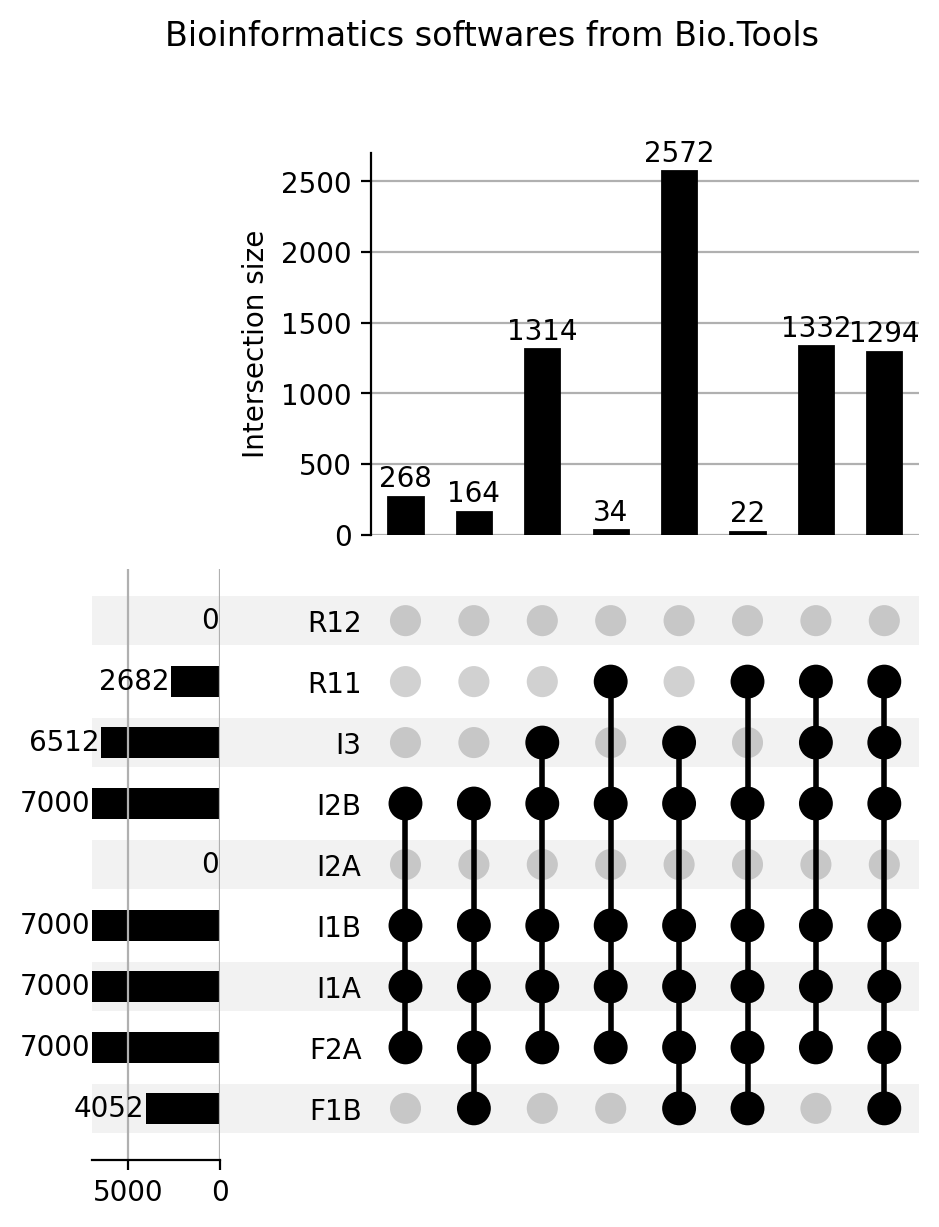

In [23]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Bioinformatics softwares from Bio.Tools")
plt.savefig('biotools-no-F2B-no-R13.png', format="png")
plt.show()

In [24]:
import seaborn as sns

df_time.drop('ID', 1, inplace=True)

/var/folders/x1/d1nyvpvs0td0htxzsv9x6ggw0000gn/T/ipykernel_8035/324344971.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_time.drop('ID', 1, inplace=True)


KeyError: "['ID'] not found in axis"

In [ ]:
sns.boxplot(data=df_time)

In [ ]:
plt.savefig('exec_time.png')

In [ ]:
#%prun -s cumulative -s module evals, exec_time = mass_eval()    

In [ ]:
#%load_ext memory_profiler
#%mprun -T mprof0 evals, exec_time = mass_eval()  

In [ ]:
#from guppy import hpy; h=hpy()

In [ ]:
#h.heap()

In [ ]:
#%load_ext watermark
#%watermark -v -m -g

In [ ]:
#%load_ext cython
#%load_ext line_profiler


In [ ]:
#%lprun -f m.evaluate mass_eval()